In [24]:
from nltk import sent_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import opinion_lexicon
from nltk.sentiment.util import mark_negation
import nltk

from nltk.tokenize import word_tokenize, sent_tokenize
from string import punctuation
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def penn_to_wn(tag):
    """
        Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [3]:
def get_sentiment_score(text):
    
    """
        This method returns the sentiment score of a given text using SentiWordNet sentiment scores.
        input: text
        output: numeric (double) score, >0 means positive sentiment and <0 means negative sentiment.
    """    
    total_score = 0
    #print(text)
    raw_sentences = sent_tokenize(text)
    #print(raw_sentences)
    
    for sentence in raw_sentences:

        sent_score = 0     
        sentence = str(sentence)
        #print(sentence)
        sentence = sentence.replace("<br />"," ").translate(str.maketrans('','',punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        tags = pos_tag(tokens)
        for word, tag in tags:
            wn_tag = penn_to_wn(tag)
            if not wn_tag:
                continue
            lemma = WordNetLemmatizer().lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sent_score += swn_synset.pos_score() - swn_synset.neg_score()

        total_score = total_score + (sent_score / len(tokens))

    
    return (total_score / len(raw_sentences)) * 100

In [4]:
reviews = pd.read_csv("./small_corpus.csv")

In [5]:
#! python -m nltk.downloader all

In [6]:
reviews['swn_score'] = reviews['reviewText'].apply(lambda text : get_sentiment_score(text))

In [7]:
reviews[['reviewText','swn_score', 'overall']].sample(2)

,reviewText,swn_score,overall
172,Doesnt smell,0.000000,2.0
274,"I usually only use liquid body soap, partly because it's a pain when I drop bar soaps, and unless I have a washcloth the lather isn't as nice. When I saw this exfoliator that firmly holds the soap in place (with Velcro no less), I decided to give it a try.\n\nThe holder is a good size and even fits a thick bar of soap. The Velcro closure works very well to firmly keep the soap inside the sleeve. The soft washing side provides a nice bubbly lather. The exfoliating side, however, if pretty rough, even using a soft touch. I really can't use it as it hurts to the point of leaving scratches on my skin. But the most concerning part about this soap envelope, however, is that it doesn't dry between showers, and that doesn't seem sanitary. On the one hand, it can be washed, but on the other I hate to think of the bacteria forming due to moisture between washes. Even 24 hours after my last shower, it's still wet (not merely damp). All in all, this is handy for those who prefer bar soap, but it's not good enough to make me switch full time from liquid body wash.",0.649351,3.0


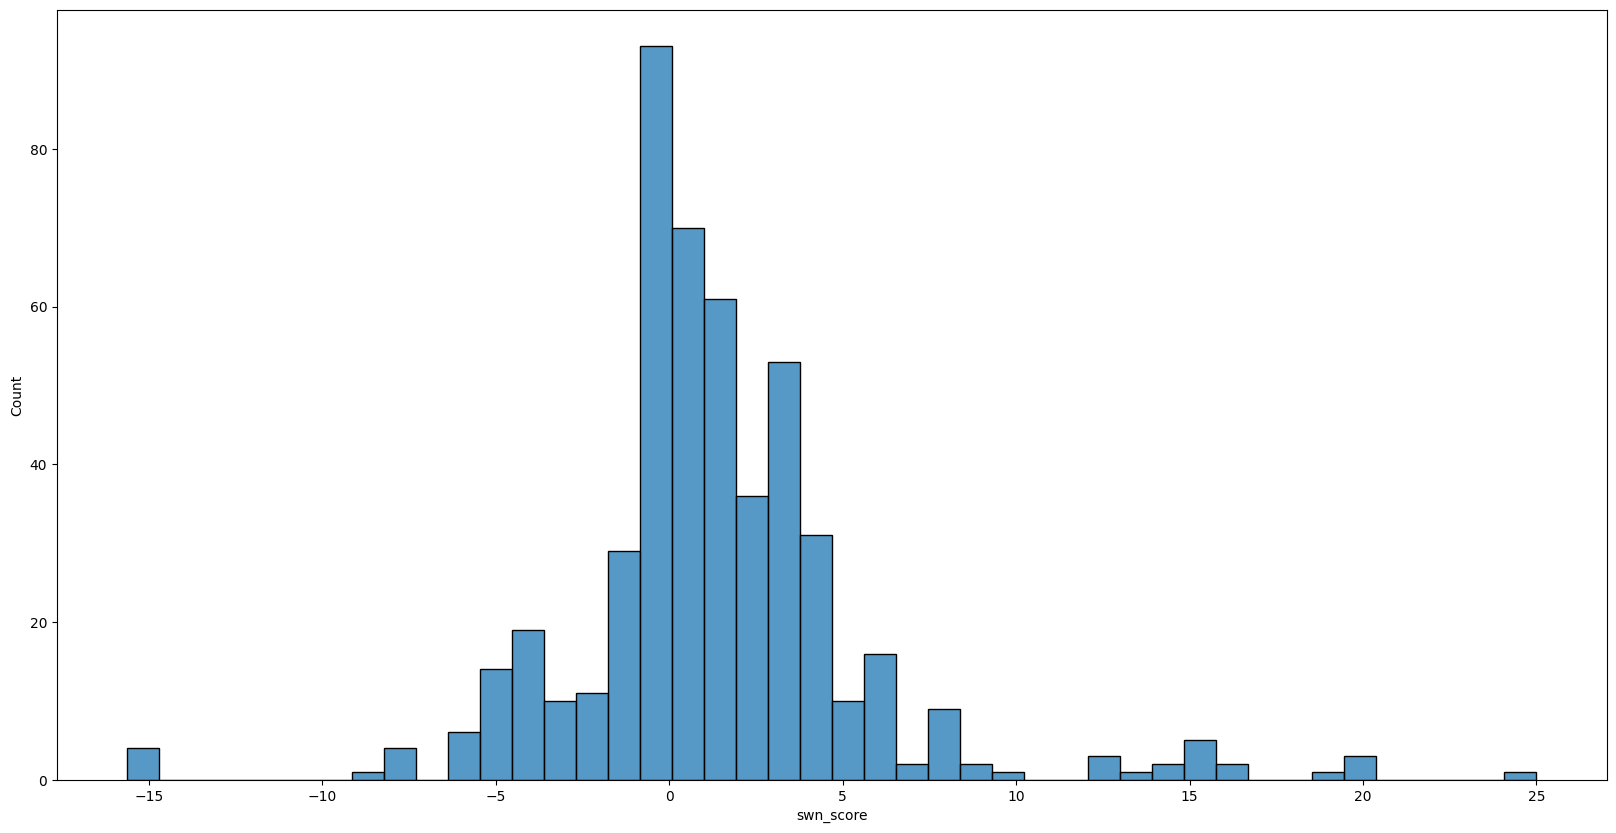

In [8]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='swn_score', data=reviews, ax=ax)
plt.show()

In [9]:
reviews['swn_sentiment'] = reviews['swn_score'].apply(lambda x: "positive" if x>1 else ("negative" if x<0.5 else "neutral"))

In [10]:
reviews['swn_sentiment'].value_counts(dropna=False)

swn_sentiment
positive    239
negative    229
neutral      32
Name: count, dtype: int64

<Axes: xlabel='swn_sentiment', ylabel='overall'>

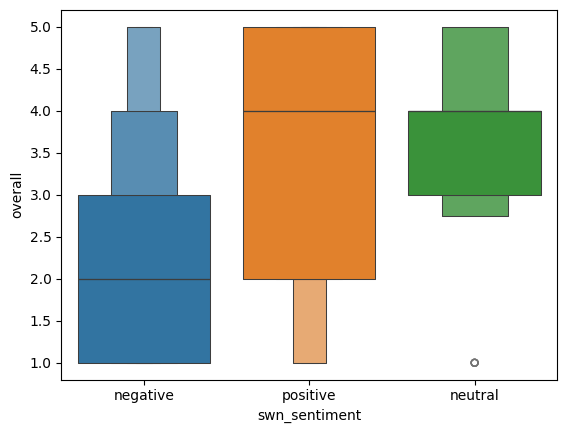

In [11]:
sns.boxenplot(x='swn_sentiment', y='overall', data=reviews, hue='swn_sentiment')

this chart looks clearer, the negative labeled reviews correlate with low ratings and vice versa

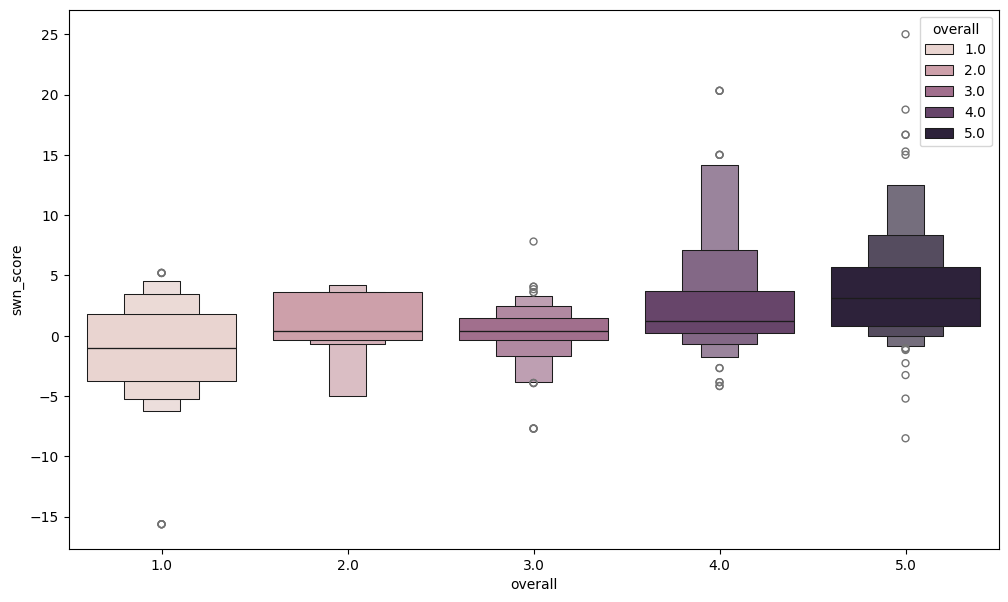

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7))
sns.boxenplot(x='overall', y='swn_score', data=reviews, hue='overall', ax=ax)
plt.show()

In [13]:
reviews['true_sentiment'] = reviews.overall.apply(lambda x: "positive" if x>=4 else "neutral" if x ==3 else "negative")


In [14]:
y_swn_pred, y_true = reviews.swn_sentiment.tolist(), reviews.true_sentiment.tolist()

In [15]:
from sklearn.metrics import confusion_matrix
labels=["negative", "neutral", "positive"]
cm = confusion_matrix(y_true, y_swn_pred, labels=labels)

In [16]:
cm

array([[120,   4,  76],
       [ 59,   5,  36],
       [ 50,  23, 127]])

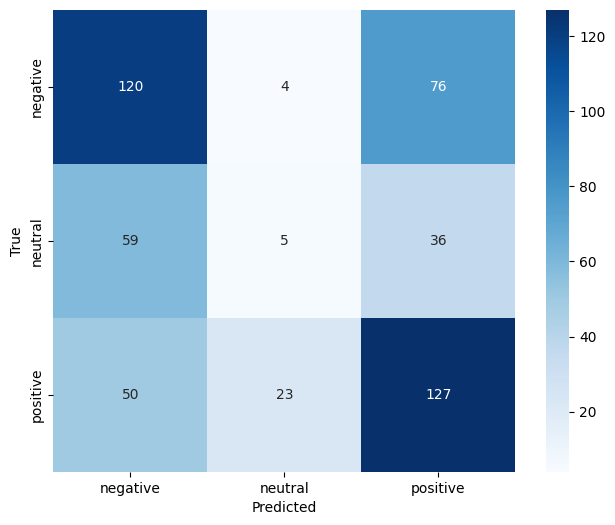

In [17]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', square=True, ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_swn_pred, average='macro')
recall = recall_score(y_true, y_swn_pred, average='macro')
f1 = f1_score(y_true, y_swn_pred, average='macro')

print(f"Precision: {precision: .2f}\nRecall: {recall: .2f}\nF1 score: {f1: .2f}")

Precision:  0.40
Recall:  0.43
F1 score:  0.40


In [30]:
# Reorganize our code into a function
def sentiment_analysis(reviews, ratings, scoring_function):
    """
    Parameters:
        reviews: Series containing text of reviews
        ratings: Series containing true rating of each review
        scoring_function: a function that takes in a review text and output a score
    Returns:
        y_true, y_pred, precision, recall, f1, lower_theshold, upper_threshold
    It will bucket the ratings and score into 3 buckets negative, positive, neutral before returning
    """
    scores = reviews.apply(scoring_function)
    lower_theshold, upper_threshold = scores.quantile(0.33), scores.quantile(0.67)
    y_pred = scores.apply(lambda s: "positive" if s > upper_threshold else "neutral" if s > lower_theshold else "negative").tolist()
    y_true = ratings.apply(lambda r: "positive" if r >=4 else "neutral" if r==3 else "negative").tolist()
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return y_true, y_pred, precision, recall, f1, lower_theshold, upper_threshold
    

In [31]:
y_true, y_pred, precision, recall, f1, lower_theshold, upper_threshold = sentiment_analysis(reviews.reviewText, reviews.overall, get_sentiment_score)

In [32]:
precision, recall, f1

(0.4894511542913369, 0.49666666666666665, 0.4866353969029707)